In [26]:
from __future__ import print_function
import numpy as np
from astropy.io import fits
import glob

## Step 1
### Make a master bias frame:

In [27]:
indir = 'C:/Users/demar/Downloads/20200306-OGSRC20/data_reduction/' # directory with data reduction images

b_list = glob.glob(indir + 'bias*.fit') # Select all FITS files with “bias” in filename, save list as “blist”


In [28]:
im,hdr = fits.getdata(b_list[0], dtype='f', header=True) # Read the first bias file pixel data and header
bias_n = len(b_list) # Number of bias images

print ('Found ', bias_n, ' bias files')

Found  10  bias files


In [29]:
bias_mean = im/float(bias_n) # Start assembling average master bias by dividing by N 

for i in range(1,bias_n): # Loop to add each bias file into average
    
    im = fits.getdata(b_list[i])
    
    bias_mean = bias_mean + im/float(bias_n)
    
#fits.writeto(indir + 'bias_mean.fits',bias_mean, hdr, overwrite=True) # Save the image as bias_mean.fits


## Step 2
### Make a master dark frame:

- Need to start by subtracting the mean bias from the from the raw dark frames. 

In [30]:
d_list = glob.glob(indir + 'dark*.fit')  

im_d,hdr = fits.getdata(d_list[0], dtype='f', header=True) 
dark_n = len(d_list) 

print('Found ', dark_n, 'dark files.') 


Found  10 dark files.


In [31]:
for i in range(0,dark_n):    # loop to subtract mean bias
    
    im_d = fits.getdata(d_list[i])
    
    basename = d_list[i].strip('.fit')
    
    dark_subtracted = im_d - bias_mean
    
    #fits.writeto(basename + '.bias.fits',dark_subtracted, hdr, overwrite=True) # the bias corrected images will have .bias at the end

Note: you should see a new file for each dark frame in your directory. It is good to double check that they are there and what they look like using DS9 specifically looking at the count of each pixel. 

### Proceed to making the master dark frame

In [32]:
d_list_2 = glob.glob(indir + 'dark*.bias.fit*') # Select all FITS files with “bias” in filename, save list as “blist”

im1,hdr = fits.getdata(d_list_2[0], dtype='f', header=True) # Read the first bias file pixel data and header

dim0 = im1.shape[0] # Dimensions of the image
dim1 = im1.shape[1]

img_array = np.zeros([dark_n,dim0,dim1]) # initialize image array

In [33]:
for i in range(0,dark_n): # loop to fill array with raw bias images
    
    im,hdr = fits.getdata(d_list_2[i], header=True)
    
    img_array[i] = im

dark_med = np.median(img_array,axis=0) # take median of each pixel in image stack

#fits.writeto(indir+'dark_med.fits',dark_med/hdr['EXPTIME'],hdr,overwrite=True) # save FITS file

## Step 3
### Make a master flat frame (for each filter):

- We need to subtract the master dark frame and bias frame from each flat frame prior to making the master flat.



In [9]:
f_list = glob.glob(indir + 'flat*.fit')  # Select all flat files, save list as "f_list"

im_f,hdr = fits.getdata(f_list[0], dtype='f', header=True)  
flat_n = len(f_list) 

print('Found ', flat_n, 'flat files.') # Check number of flat files

Found  15 flat files.


#### Subtract mean bias from flat frame

In [10]:
for i in range(0,flat_n):      # Loop to subtract mean bias 
    
    im_f = fits.getdata(f_list[i]) 
    
    basename = f_list[i].strip('.fit')
    
    flat_subtracted = im_f - bias_mean
    
    fits.writeto(basename+'.bias.fits',flat_subtracted, hdr, overwrite=True) 

#### Subtract master dark frame from flat frame

In [11]:
f_list_2 = glob.glob(indir + 'flat*.bias.fits*')  # Assigning all bias subtracted flat files to f_list_2
flat_n = len(f_list_2)

print('Found ', flat_n, 'flat files.') # Check number of flat files

Found  15 flat files.


In [12]:
for i in range(0,flat_n):      # Loop to subtract the master dark frame from each flat file frame
    
    im_f,hdr = fits.getdata(f_list_2[i], header=True) 
    
    basename = f_list_2[i].strip('.fits')
    
    dark_subtracted = im_f - dark_med
    
    fits.writeto(basename+'.dark.fits',dark_subtracted, hdr, overwrite=True) 

#### Proceed to making the master flat field frame

In [4]:
filters = ['B','R','V'] # List of filter names used in this dataset

for filter in filters: # Loop through the list of filters one at a time
    
    flat_list = glob.glob(indir + 'flat*' + filter + '.bia.dark.fits')  
    
    im_f,hdr = fits.getdata(flat_list[0], dtype='f', header=True)  # Data for first flat file
    
    flat_n = len(flat_list) #number of flat files()
    
    print('Found ', flat_n, filter, 'flat files.') # Print number of flat files

    dim0 = im_f.shape[0] # get dimensions of the images
    dim1 = im_f.shape[1]
    
    img_array = np.zeros([flat_n,dim0,dim1]) # Initialize image array
    
    for i in range(0,flat_n):      # Loop to choose the median value for each pixel to make master flat
        
        im_f,hdr = fits.getdata(flat_list[i], header=True) 
        
        img_array[i] = im_f 
    
    masterflat = np.median(img_array, axis=0)
    
    fits.writeto(indir+'masterflat_'+filter+'.fits',masterflat/np.median(masterflat), hdr, overwrite=True)

Found  5 B flat files.
Found  5 R flat files.
Found  5 V flat files.


## Step 4: Reduce the science images.

In [76]:
sci_dir = 'C:/Users/demar/Downloads/20200306-OGSRC20/20200306-OGSRC20/NGC1912/' # Directory for every science image

sci_list = glob.glob(sci_dir + 'light*.fit')  # Assigning all science image files to sci_list

im_s,hdr = fits.getdata(sci_list[0], dtype='f', header=True) # Data for first science file
 
sci_n = len(sci_list) 

print('Found ', sci_n, 'science files.')

Found  3 science files.


#### Subtract master bias frame and dark frame from science images 

In [77]:
# Loop through science images and subtract the mean bias

for i in range(0,sci_n):    
    
    im_s = fits.getdata(sci_list[i])
    
    basename = sci_list[i].strip('.fit')
    
    bias_subtracted = im_s - bias_mean 
    
    dark_bias_sub = bias_subtracted - dark_med

    fits.writeto(basename+'.bias.dark.fit',bias_subtracted, hdr, overwrite=True) 
    

#### Finish data reduction by dividing the images by the master flat

In [78]:
filters = ['B','R','V']

for filter in filters: # Using the same filters as before

    sci_list = glob.glob(sci_dir + 'light_*' + filter + '*bias.dark.fit') 
    
    sci_n = len(sci_list) 

    print('Found ', sci_n, filter, 'science files.') 

    master_flat = fits.getdata(indir + 'masterflat_' + filter + '.fits')
    
    for i in range(0,sci_n):      
        
        im_s,hdr = fits.getdata(sci_list[i], header=True) 
        
        basename = sci_list[i].strip('.fits')
        
        reduced_sci = im_s/master_flat

        fits.writeto(basename + '.reduced.fits',reduced_sci, hdr, overwrite=True)

Found  1 B science files.
Found  1 R science files.
Found  1 V science files.


Note: to distinguish the fully reduced files you can put them in another folder, to view them you may use DS9 and check the counts to see how they differ from the original. 

## Step 5
reduce data to create a color magnitude diagram of the NGC2099 cluster

In [81]:
import matplotlib.pyplot as plt
import pandas as pd

Text(0, 0.5, 'Vr - Relative Magnitude\n(with respect to reference star)')

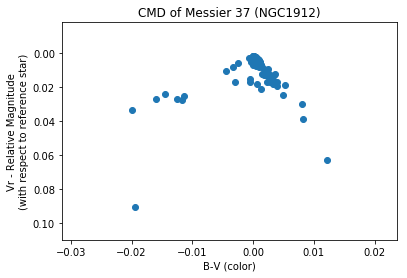

In [128]:
# import B & V reduced image files:
sci_list_B = glob.glob(sci_dir + 'light_B*bias.dark.fit')
sci_list_V = glob.glob(sci_dir + 'light_V*bias.dark.fit')

b_data = pd.read_excel(sci_dir + 'B_Measurements.xlsx', sheet_name = 'data')
v_data = pd.read_excel(sci_dir + 'V_Measurement.xlsx', sheet_name = 'data')

# find the difference of the B and V band magnitudes (B-V)
difference = b_data - v_data

# plot the resuling magnitudes
plt.scatter(difference,v_data)
plt.gca().invert_yaxis()
plt.title('CMD of Messier 37 (NGC1912)')
plt.xlabel('B-V (color)')
plt.ylabel('Vr - Relative Magnitude\n(with respect to reference star)')